In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score

In [ ]:
# Load data
train = pd.read_csv("/content/train_phone.csv")      # has price_range
test  = pd.read_csv("/content/test_phone.csv")       # no price_range

In [ ]:
# Basic checks
print(train.shape, test.shape)
print(train.isna().sum().sum(), test.isna().sum().sum())
print(train.duplicated().sum())


(2000, 21) (1000, 21)
0 0
0


In [ ]:
# Split labeled data with stratification
X = train.drop(columns=["price_range"])
y = train["price_range"]
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Baseline tree (Gini)
base = DecisionTreeClassifier(criterion="gini", random_state=42)
base.fit(X_tr, y_tr)
print("Baseline acc:", base.score(X_va, y_va))

Baseline acc: 0.83


In [ ]:
# Cost-complexity pruning sweep
path = base.cost_complexity_pruning_path(X_tr, y_tr)
alphas = path.ccp_alphas
best_alpha, best_acc = 0.0, -np.inf
for a in alphas:
    clf = DecisionTreeClassifier(criterion="gini", ccp_alpha=a, random_state=42)
    clf.fit(X_tr, y_tr)
    acc = clf.score(X_va, y_va)
    if acc > best_acc:
        best_acc, best_alpha = acc, a
print("Chosen ccp_alpha:", best_alpha, "Val acc:", best_acc)


Chosen ccp_alpha: 0.0009375 Val acc: 0.85


In [ ]:
# Final model on full training data
final = DecisionTreeClassifier(criterion="gini", ccp_alpha=best_alpha, random_state=42)
final.fit(X, y)
va_pred = final.predict(X_va)
print("Validation acc:", accuracy_score(y_va, va_pred))
print(classification_report(y_va, va_pred))

Validation acc: 0.9775
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       0.95      0.98      0.97       100
           2       0.98      0.94      0.96       100
           3       0.98      1.00      0.99       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



In [ ]:
# Predict test and save in required format
test_pred = final.predict(test.drop(columns=["id"]) if "id" in test.columns else test)
sub = pd.DataFrame({"id": test["id"], "price_range": test_pred})
sub.to_csv("submission.csv", index=False)

In [ ]:
# file: ml_utils.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
def build_pipeline(model_name: str, params: dict):
    if model_name == "Decision Tree":
        clf = DecisionTreeClassifier(
            criterion="gini",
            max_depth=params.get("max_depth"),
            min_samples_split=params.get("min_samples_split", 2),
            min_samples_leaf=params.get("min_samples_leaf", 1),
            ccp_alpha=params.get("ccp_alpha", 0.0),
            random_state=42,
        )
        return Pipeline([("clf", clf)])
    if model_name == "Logistic Regression":
        clf = LogisticRegression(
            multi_class="multinomial",
            solver=params.get("solver", "lbfgs"),
            C=params.get("C", 1.0),
            max_iter=params.get("max_iter", 200),
            n_jobs=None if params.get("solver","lbfgs")=="lbfgs" else -1,
            random_state=42,
        )
        return Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    if model_name == "Random Forest":
        clf = RandomForestClassifier(
            n_estimators=params.get("n_estimators", 300),
            max_depth=params.get("max_depth"),
            min_samples_split=params.get("min_samples_split", 2),
            min_samples_leaf=params.get("min_samples_leaf", 1),
            max_features=params.get("max_features", "sqrt"),
            n_jobs=-1,
            random_state=42,
        )
        return Pipeline([("clf", clf)])
    if model_name == "KNN":
        clf = KNeighborsClassifier(
            n_neighbors=params.get("n_neighbors", 15),
            weights=params.get("weights", "distance"),
            metric=params.get("metric", "minkowski"),
            p=params.get("p", 2),
            n_jobs=-1,
        )
        return Pipeline([("scaler", StandardScaler()), ("clf", clf)])
    raise ValueError("Unknown model")

In [ ]:
def load_split(train_path: str, test_size=0.2):
    df = pd.read_csv(train_path)
    X = df.drop(columns=["price_range"])
    y = df["price_range"]
    X_tr, X_va, y_tr, y_va = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    return df, X_tr, X_va, y_tr, y_va

In [ ]:
def fit_eval(pipeline: Pipeline, X_tr, X_va, y_tr, y_va):
    pipeline.fit(X_tr, y_tr)
    va_pred = pipeline.predict(X_va)
    acc = accuracy_score(y_va, va_pred)
    report = classification_report(y_va, va_pred, output_dict=False)
    return acc, report, pipeline


In [ ]:
def predict_test(fitted: Pipeline, test_df: pd.DataFrame):
    Xtest = test_df.drop(columns=["id"]) if "id" in test_df.columns else test_df
    preds = fitted.predict(Xtest)
    return preds

In [ ]:
# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(criterion="gini", random_state=42),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500, random_state=42)),
    ]),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=42),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=15, weights="distance", n_jobs=-1)),
    ]),
}

In [ ]:
for name, model in models.items():
    model.fit(X_tr, y_tr)
    preds = model.predict(X_va)
    acc = accuracy_score(y_va, preds)
    bacc = balanced_accuracy_score(y_va, preds)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced accuracy: {bacc:.4f}")
    print(classification_report(y_va, preds, digits=4))


=== Decision Tree ===
Accuracy: 0.8300
Balanced accuracy: 0.8300
              precision    recall  f1-score   support

           0     0.8762    0.9200    0.8976       100
           1     0.7789    0.7400    0.7590       100
           2     0.7477    0.8000    0.7729       100
           3     0.9247    0.8600    0.8912       100

    accuracy                         0.8300       400
   macro avg     0.8319    0.8300    0.8302       400
weighted avg     0.8319    0.8300    0.8302       400


=== Logistic Regression ===
Accuracy: 0.9650
Balanced accuracy: 0.9650
              precision    recall  f1-score   support

           0     0.9899    0.9800    0.9849       100
           1     0.9600    0.9600    0.9600       100
           2     0.9495    0.9400    0.9447       100
           3     0.9608    0.9800    0.9703       100

    accuracy                         0.9650       400
   macro avg     0.9650    0.9650    0.9650       400
weighted avg     0.9650    0.9650    0.9650    

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Random Forest ===
Accuracy: 0.8800
Balanced accuracy: 0.8800
              precision    recall  f1-score   support

           0     0.9406    0.9500    0.9453       100
           1     0.8039    0.8200    0.8119       100
           2     0.8182    0.8100    0.8141       100
           3     0.9592    0.9400    0.9495       100

    accuracy                         0.8800       400
   macro avg     0.8805    0.8800    0.8802       400
weighted avg     0.8805    0.8800    0.8802       400


=== KNN ===
Accuracy: 0.5725
Balanced accuracy: 0.5725
              precision    recall  f1-score   support

           0     0.7791    0.6700    0.7204       100
           1     0.4273    0.4700    0.4476       100
           2     0.4340    0.4600    0.4466       100
           3     0.7041    0.6900    0.6970       100

    accuracy                         0.5725       400
   macro avg     0.5861    0.5725    0.5779       400
weighted avg     0.5861    0.5725    0.5779       400



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import LearningCurveDisplay

In [ ]:
df = pd.read_csv("train_phone.csv")
X = df.drop(columns=["price_range"])
y = df["price_range"]

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

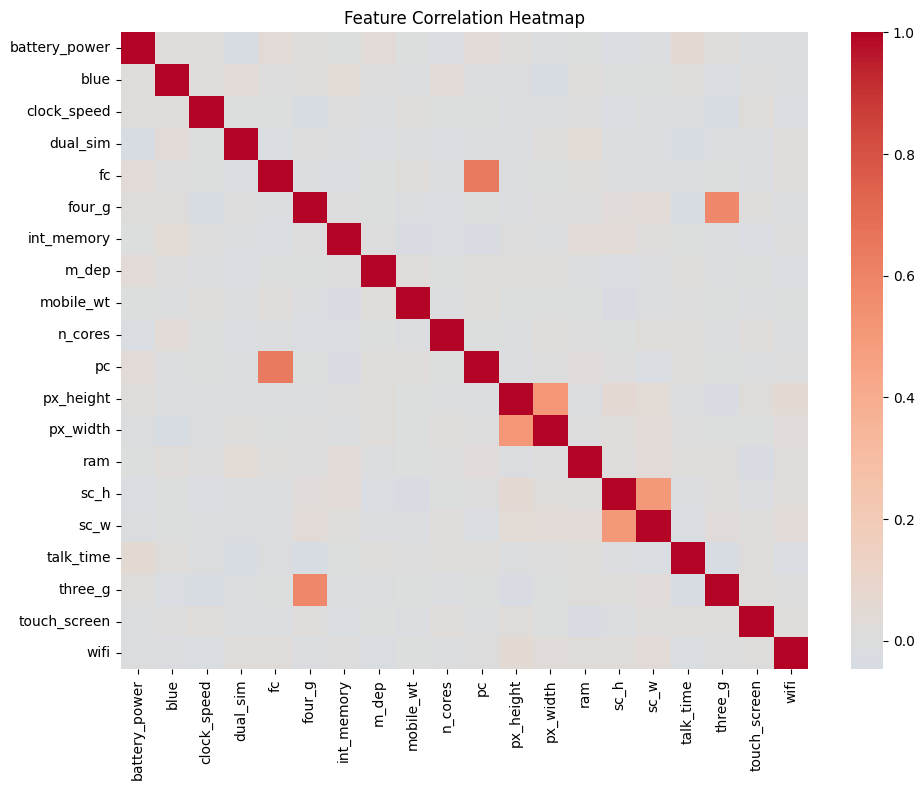

In [25]:
# Correlation heatmap of features
plt.figure(figsize=(10, 8))
corr = X.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0, square=False)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

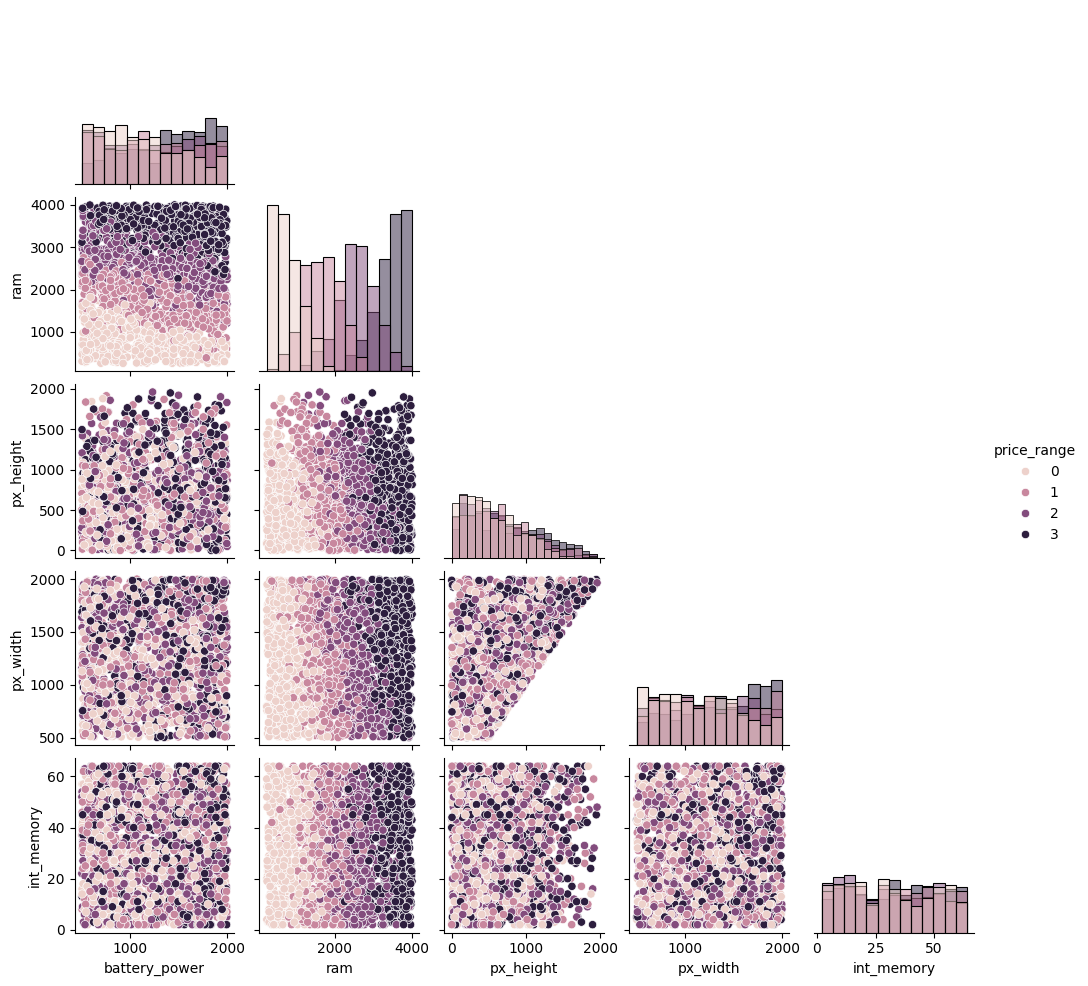

In [27]:
# Pairplot for a focused subset (keeps it fast)
subset_cols = ["battery_power", "ram", "px_height", "px_width", "int_memory", "price_range"]
sns.pairplot(train[subset_cols], hue="price_range", corner=True, diag_kind="hist", height=2.0)
plt.show()

In [28]:
# Train four models

models = {
    "Decision Tree": DecisionTreeClassifier(criterion="gini", random_state=42),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500, random_state=42)),
    ]),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=15, weights="distance", n_jobs=-1)),
    ]),
}

accuracies = {}
fitted = {}
for name, est in models.items():
    est.fit(X_tr, y_tr)
    fitted[name] = est
    preds = est.predict(X_va)
    accuracies[name] = accuracy_score(y_va, preds)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


/tmp/ipython-input-4272508032.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=vals, palette="viridis")


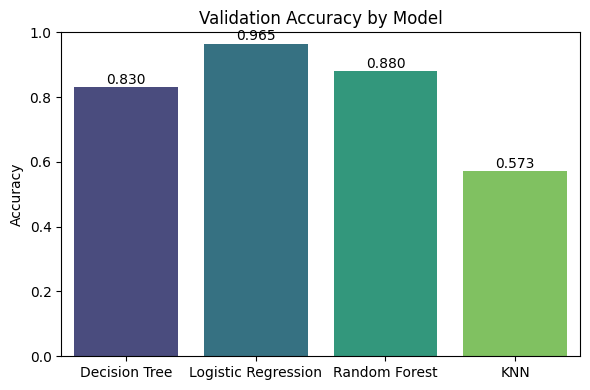

In [29]:
# Accuracy bar chart

plt.figure(figsize=(6, 4))
names = list(accuracies.keys())
vals = [accuracies[k] for k in names]
sns.barplot(x=names, y=vals, palette="viridis")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Validation Accuracy by Model")
for i, v in enumerate(vals):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.tight_layout()
plt.show()


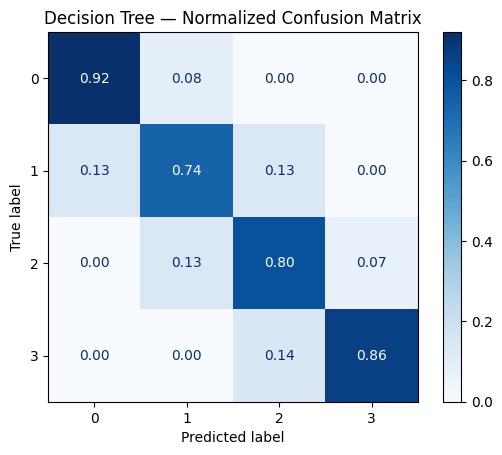

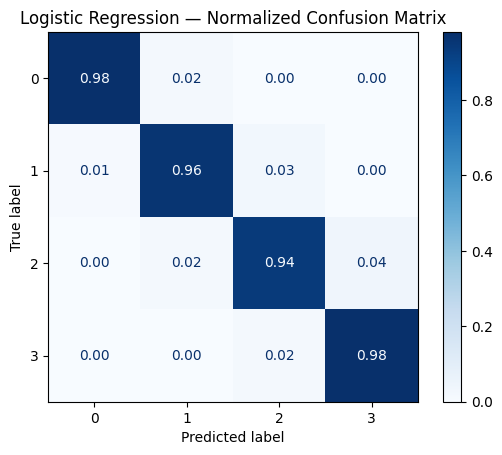

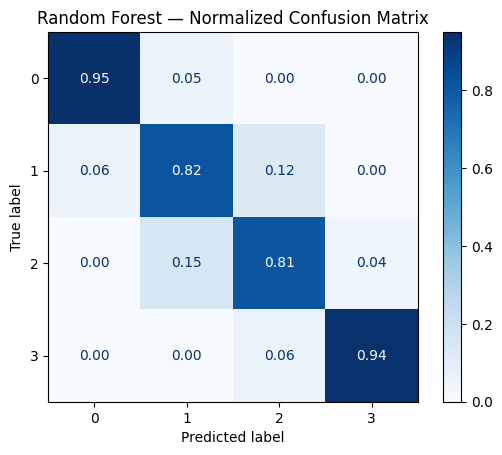

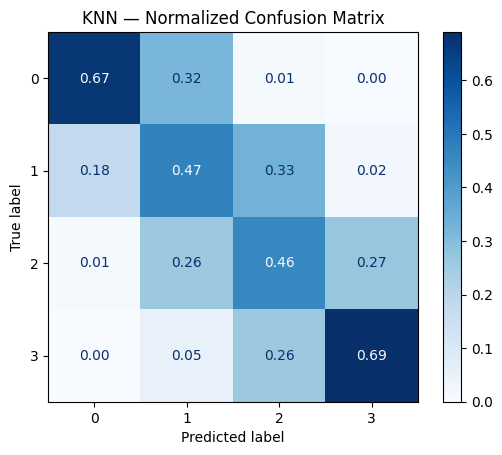

In [30]:
# Confusion matrices (normalized)

for name, est in fitted.items():
    preds = est.predict(X_va)
    cm = confusion_matrix(y_va, preds, labels=sorted(y.unique()), normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
    disp.plot(values_format=".2f", cmap="Blues")
    disp.ax_.set_title(f"{name} — Normalized Confusion Matrix")
    plt.show()